In [33]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [34]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                      n_features = 5, n_informative = 5, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

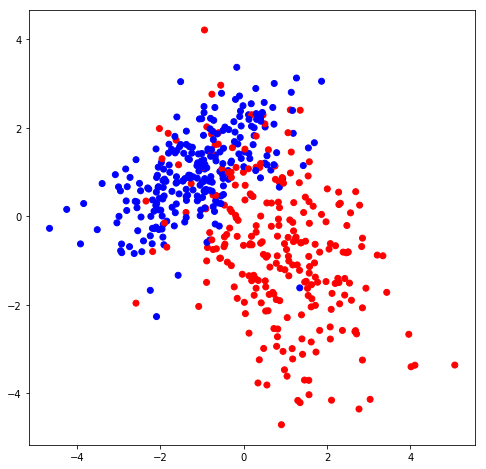

In [35]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [36]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [37]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [38]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch, data):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        self.data = data

In [39]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction 

In [40]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [41]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [42]:
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [43]:
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [44]:
def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch, data)

In [45]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [46]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [47]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [48]:
def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [69]:
from sklearn import model_selection
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [72]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Задание 1: Оценка алгоритма на основе OOB 

In [62]:
oob_predictions = []
oob_true_value = []
for i in range(len(train_data)):
    ouf_of_bag_predictions = []
    for tree in my_forest_10:
        if not train_data[i] in tree.data:
            ouf_of_bag_predictions.append(predict([train_data[i]], tree)[0])
    if len(ouf_of_bag_predictions) > 0:
        result_prediction = max(set(ouf_of_bag_predictions), key=ouf_of_bag_predictions.count)
        oob_predictions.append(result_prediction)
        oob_true_value.append(train_labels[i])

In [93]:
def calc_oob(data, labels, forest):
    oob_predictions = []
    oob_true_values = []
    for i in range(len(data)):
        ouf_of_bag_predictions = []
        for tree in forest:
            if not data[i] in tree.data:
                ouf_of_bag_predictions.append(predict([data[i]], tree)[0])
        if len(ouf_of_bag_predictions) > 0:
            result_prediction = max(set(ouf_of_bag_predictions), key=ouf_of_bag_predictions.count)
            oob_predictions.append(result_prediction)
            oob_true_values.append(labels[i])
    return oob_true_values, oob_predictions 

In [75]:
n_trees = 10

my_forest_10 = random_forest(train_data, train_labels, n_trees)
train_answers = tree_vote(my_forest_10, train_data)
test_answers = tree_vote(my_forest_10, test_data)

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')


test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 99.714
Точность случайного леса из 10 деревьев на тестовой выборке: 95.333


In [96]:
oob_data = calc_oob(classification_data, classification_labels, my_forest_10)
oob_accuracy = accuracy_metric(oob_data[0], oob_data[1])
print(f'Точность случайного леса из {n_trees} деревьев по oob: {oob_accuracy:.3f}')

Точность случайного леса из 3 деревьев по oob: 88.956


In [98]:
n_trees = 50

my_forest_50 = random_forest(train_data, train_labels, n_trees)
train_answers = tree_vote(my_forest_50, train_data)
test_answers = tree_vote(my_forest_50, test_data)

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')


test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 96.667


In [101]:
oob_data = calc_oob(classification_data, classification_labels, my_forest_50)
oob_accuracy = accuracy_metric(oob_data[0], oob_data[1])
print(f'Точность случайного леса из {n_trees} деревьев по oob: {oob_accuracy:.3f}')

Точность случайного леса из 50 деревьев по oob: 92.200


In [102]:
n_trees = 75

my_forest_75 = random_forest(train_data, train_labels, n_trees)
train_answers = tree_vote(my_forest_75, train_data)
test_answers = tree_vote(my_forest_75, test_data)

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')


test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 75 деревьев на обучающей выборке: 100.000
Точность случайного леса из 75 деревьев на тестовой выборке: 96.000


In [104]:
oob_data = calc_oob(classification_data, classification_labels, my_forest_75)
oob_accuracy = accuracy_metric(oob_data[0], oob_data[1])
print(f'Точность случайного леса из {n_trees} деревьев по oob: {oob_accuracy:.3f}')

Точность случайного леса из 75 деревьев по oob: 92.200


In [105]:
n_trees = 25

my_forest_25 = random_forest(train_data, train_labels, n_trees)
train_answers = tree_vote(my_forest_25, train_data)
test_answers = tree_vote(my_forest_25, test_data)

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')


test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 25 деревьев на обучающей выборке: 99.714
Точность случайного леса из 25 деревьев на тестовой выборке: 96.667


In [107]:
oob_data = calc_oob(classification_data, classification_labels, my_forest_25)
oob_accuracy = accuracy_metric(oob_data[0], oob_data[1])
print(f'Точность случайного леса из {n_trees} деревьев по oob: {oob_accuracy:.3f}')

Точность случайного леса из 25 деревьев по oob: 92.585


In [111]:
n_trees = 3

my_forest_3 = random_forest(train_data, train_labels, n_trees)
train_answers = tree_vote(my_forest_3, train_data)
test_answers = tree_vote(my_forest_3, test_data)

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')


test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 98.286
Точность случайного леса из 3 деревьев на тестовой выборке: 91.333


In [112]:
oob_data = calc_oob(classification_data, classification_labels, my_forest_3)
oob_accuracy = accuracy_metric(oob_data[0], oob_data[1])
print(f'Точность случайного леса из {n_trees} деревьев по oob: {oob_accuracy:.3f}')

Точность случайного леса из 3 деревьев по oob: 86.925
